In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [2]:
sys.path.append(os.path.abspath(".."))

from ners.core.config import setup_config
from ners.core.utils.data_loader import DataLoader
from ners.core.config.pipeline_config import PipelineConfig

In [3]:
config = setup_config()
loader = DataLoader(config)

2025-10-05 22:52:21,813 - root - INFO - Ensured all required directories exist
2025-10-05 22:52:21,821 - root - INFO - Loaded configuration: drc_names_pipeline v1.0.0
2025-10-05 22:52:21,829 - root - INFO - Environment: development
2025-10-05 22:52:21,834 - root - INFO - Config file: config/pipeline.development.yaml


In [4]:
gdf = gpd.read_file("../../assets/osm/provinces.shp")
gdf_proj = gdf.to_crs(epsg=32732)
gdf["centroid"] = gdf_proj.geometry.centroid.to_crs(gdf.crs)

df = loader.load_csv_complete(config.paths.data_dir / "names_featured.csv")

2025-10-05 22:52:40,492 - root - INFO - Reading /Users/bernard-ng/dev/community/analysis/drc-ners-nlp/data/dataset/names_featured.csv with encoding: utf-8
2025-10-05 22:55:58,779 - root - INFO - Successfully read /Users/bernard-ng/dev/community/analysis/drc-ners-nlp/data/dataset/names_featured.csv with encoding: utf-8
2025-10-05 22:55:58,884 - root - INFO - Concatenating 65 optimized chunks


## Breakdown by Province

In [5]:
import unicodedata


# Helper function for cleaning province names
def clean_province(s):
    return (
        s.str.upper()
        .str.strip()
        .apply(
            lambda x: unicodedata.normalize("NFKD", x)
            .encode("ascii", errors="ignore")
            .decode("utf-8")
            if isinstance(x, str)
            else x
        )
    )


# Apply to both DataFrames
df["province"] = clean_province(df["province"])
gdf["province"] = clean_province(gdf["name"])

# Group and merge
counts = df["province"].value_counts().reset_index()
counts.columns = ["province", "count"]

gdf = gdf.merge(counts, left_on="province", right_on="province", how="left")

In [6]:
gdf.head(12)

,full_id,name,geometry,centroid,province,count
0,r5646651,Kinshasa,"POLYGON ((16.03321 -4.98926, 16.02639 -4.98868...",POINT (15.89714 -4.45276),KINSHASA,1140620
1,r193090,Bas-Congo,"POLYGON ((15.64766 -4.91155, 15.6477 -4.91174,...",POINT (14.28812 -5.2961),BAS-CONGO,295155
2,r5642699,Sud-Kivu,"POLYGON ((29.24225 -1.69991, 29.24228 -1.69991...",POINT (28.26546 -3.22633),SUD-KIVU,346152
3,r5642698,Nord-Kivu,"POLYGON ((29.39797 0.81304, 29.39806 0.81285, ...",POINT (28.70741 -0.60502),NORD-KIVU,394999
4,r5642697,Maniema,"POLYGON ((28.19331 -4.15135, 28.19369 -4.15152...",POINT (26.39038 -3.06735),MANIEMA,127813
5,r193087,Kasaï-Occidental,"POLYGON ((23.28516 -6.91736, 23.286 -6.91859, ...",POINT (21.62853 -5.4419),KASAI-OCCIDENTAL,367626
6,r193088,Kasaï-Oriental,"POLYGON ((23.28042 -7.98622, 23.28018 -7.98616...",POINT (23.94445 -4.54154),KASAI-ORIENTAL,434497
7,r3652052,Équateur,"POLYGON ((23.31621 -0.24045, 23.31099 -0.24055...",POINT (20.63056 1.02935),EQUATEUR,356404
8,r3652285,Orientale,"POLYGON ((23.08876 -0.40575, 23.08401 -0.40572...",POINT (26.42917 2.12421),ORIENTALE,322756
9,r3652335,Bandundu,"POLYGON ((20.35736 -2.19989, 20.36211 -2.20019...",POINT (18.35771 -4.37828),BANDUNDU,809949


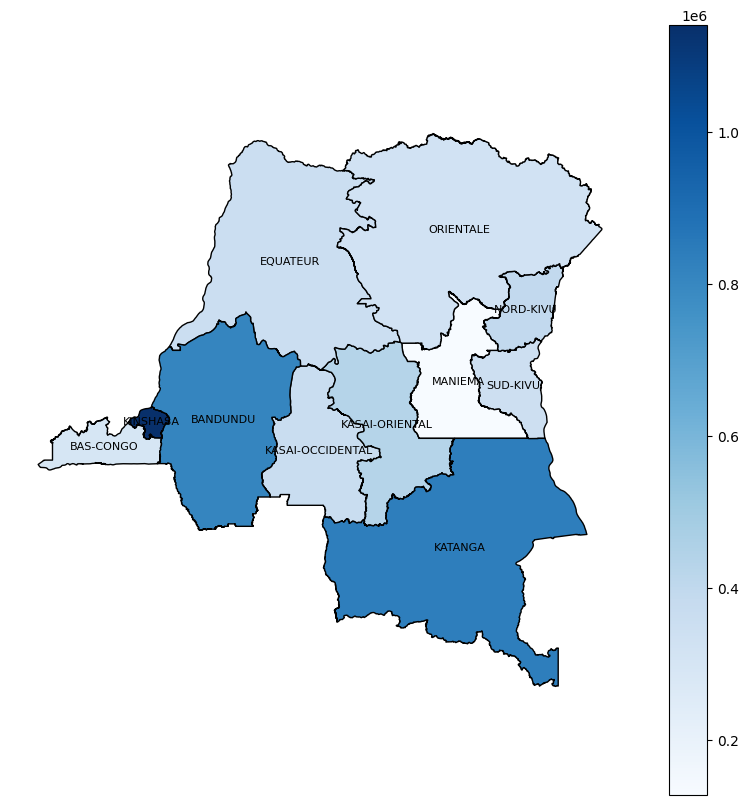

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(column="count", cmap="Blues", edgecolor="black", legend=True, ax=ax)
labels = gdf.loc[gdf["count"].notna(), ["province", "centroid"]]

for _, row in labels.iterrows():
    ax.annotate(
        text=row["province"],
        xy=(row["centroid"].x, row["centroid"].y),
        ha="center",
        va="center",
        fontsize=8,
        color="black",
    )

ax.axis("off")
plt.show()

## Distribution

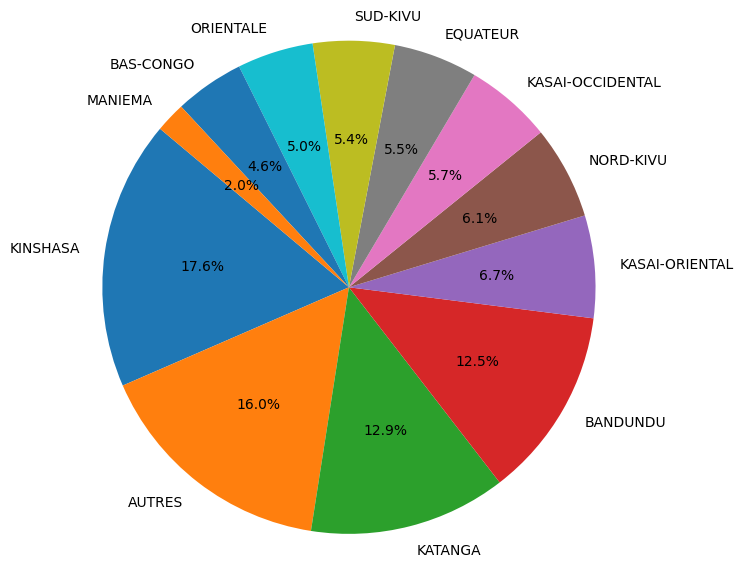

In [18]:
provinces = df["province"].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(provinces, labels=provinces.index, autopct="%1.1f%%", startangle=140)
plt.axis("equal")
plt.show()

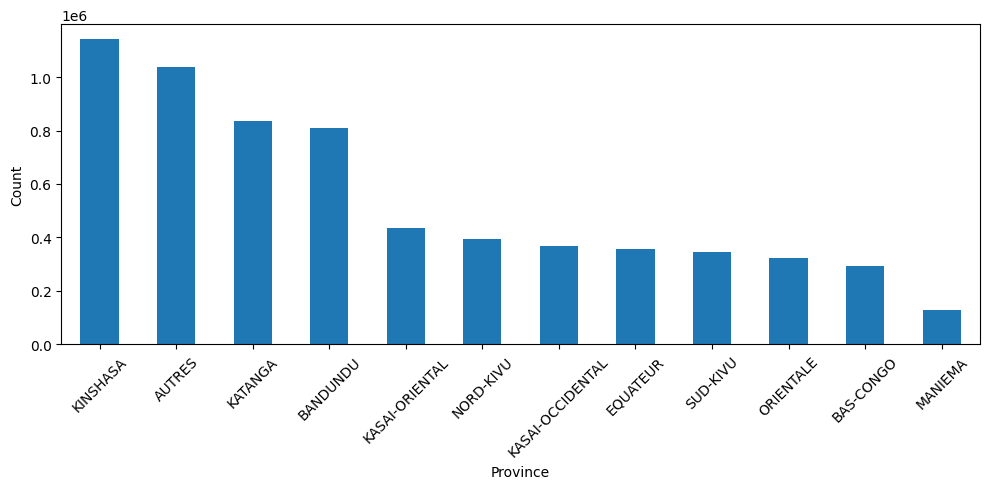

In [19]:
plt.figure(figsize=(10, 5))
provinces.plot(kind="bar")
plt.xlabel("Province")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

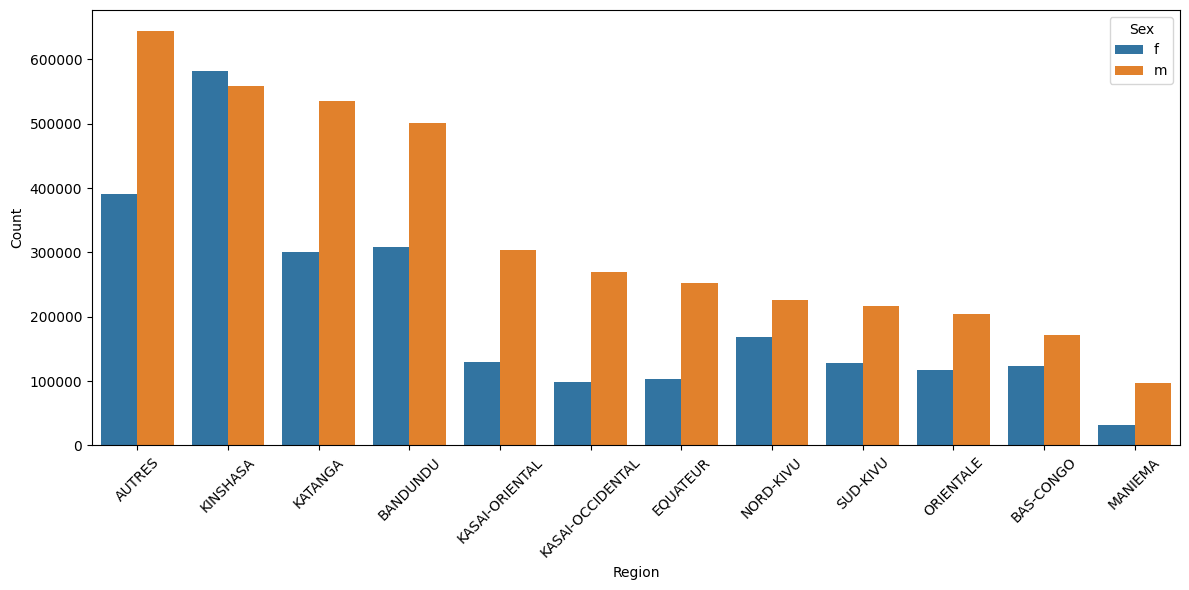

In [10]:
plt.show()
data = df.groupby(["province", "sex"], observed=False).size().reset_index(name="count")
data = data.sort_values("count", ascending=False).drop_duplicates(["province", "sex"])

plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="province", y="count", hue="sex")

plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

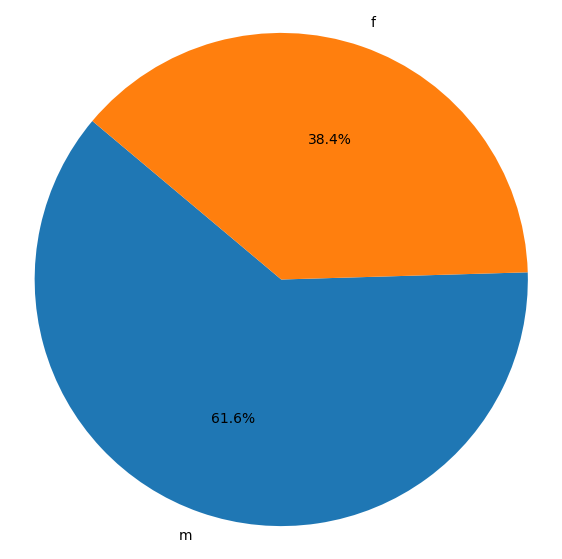

In [11]:
sex = df["sex"].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(sex, labels=sex.index, autopct="%1.1f%%", startangle=140)
plt.axis("equal")
plt.show()

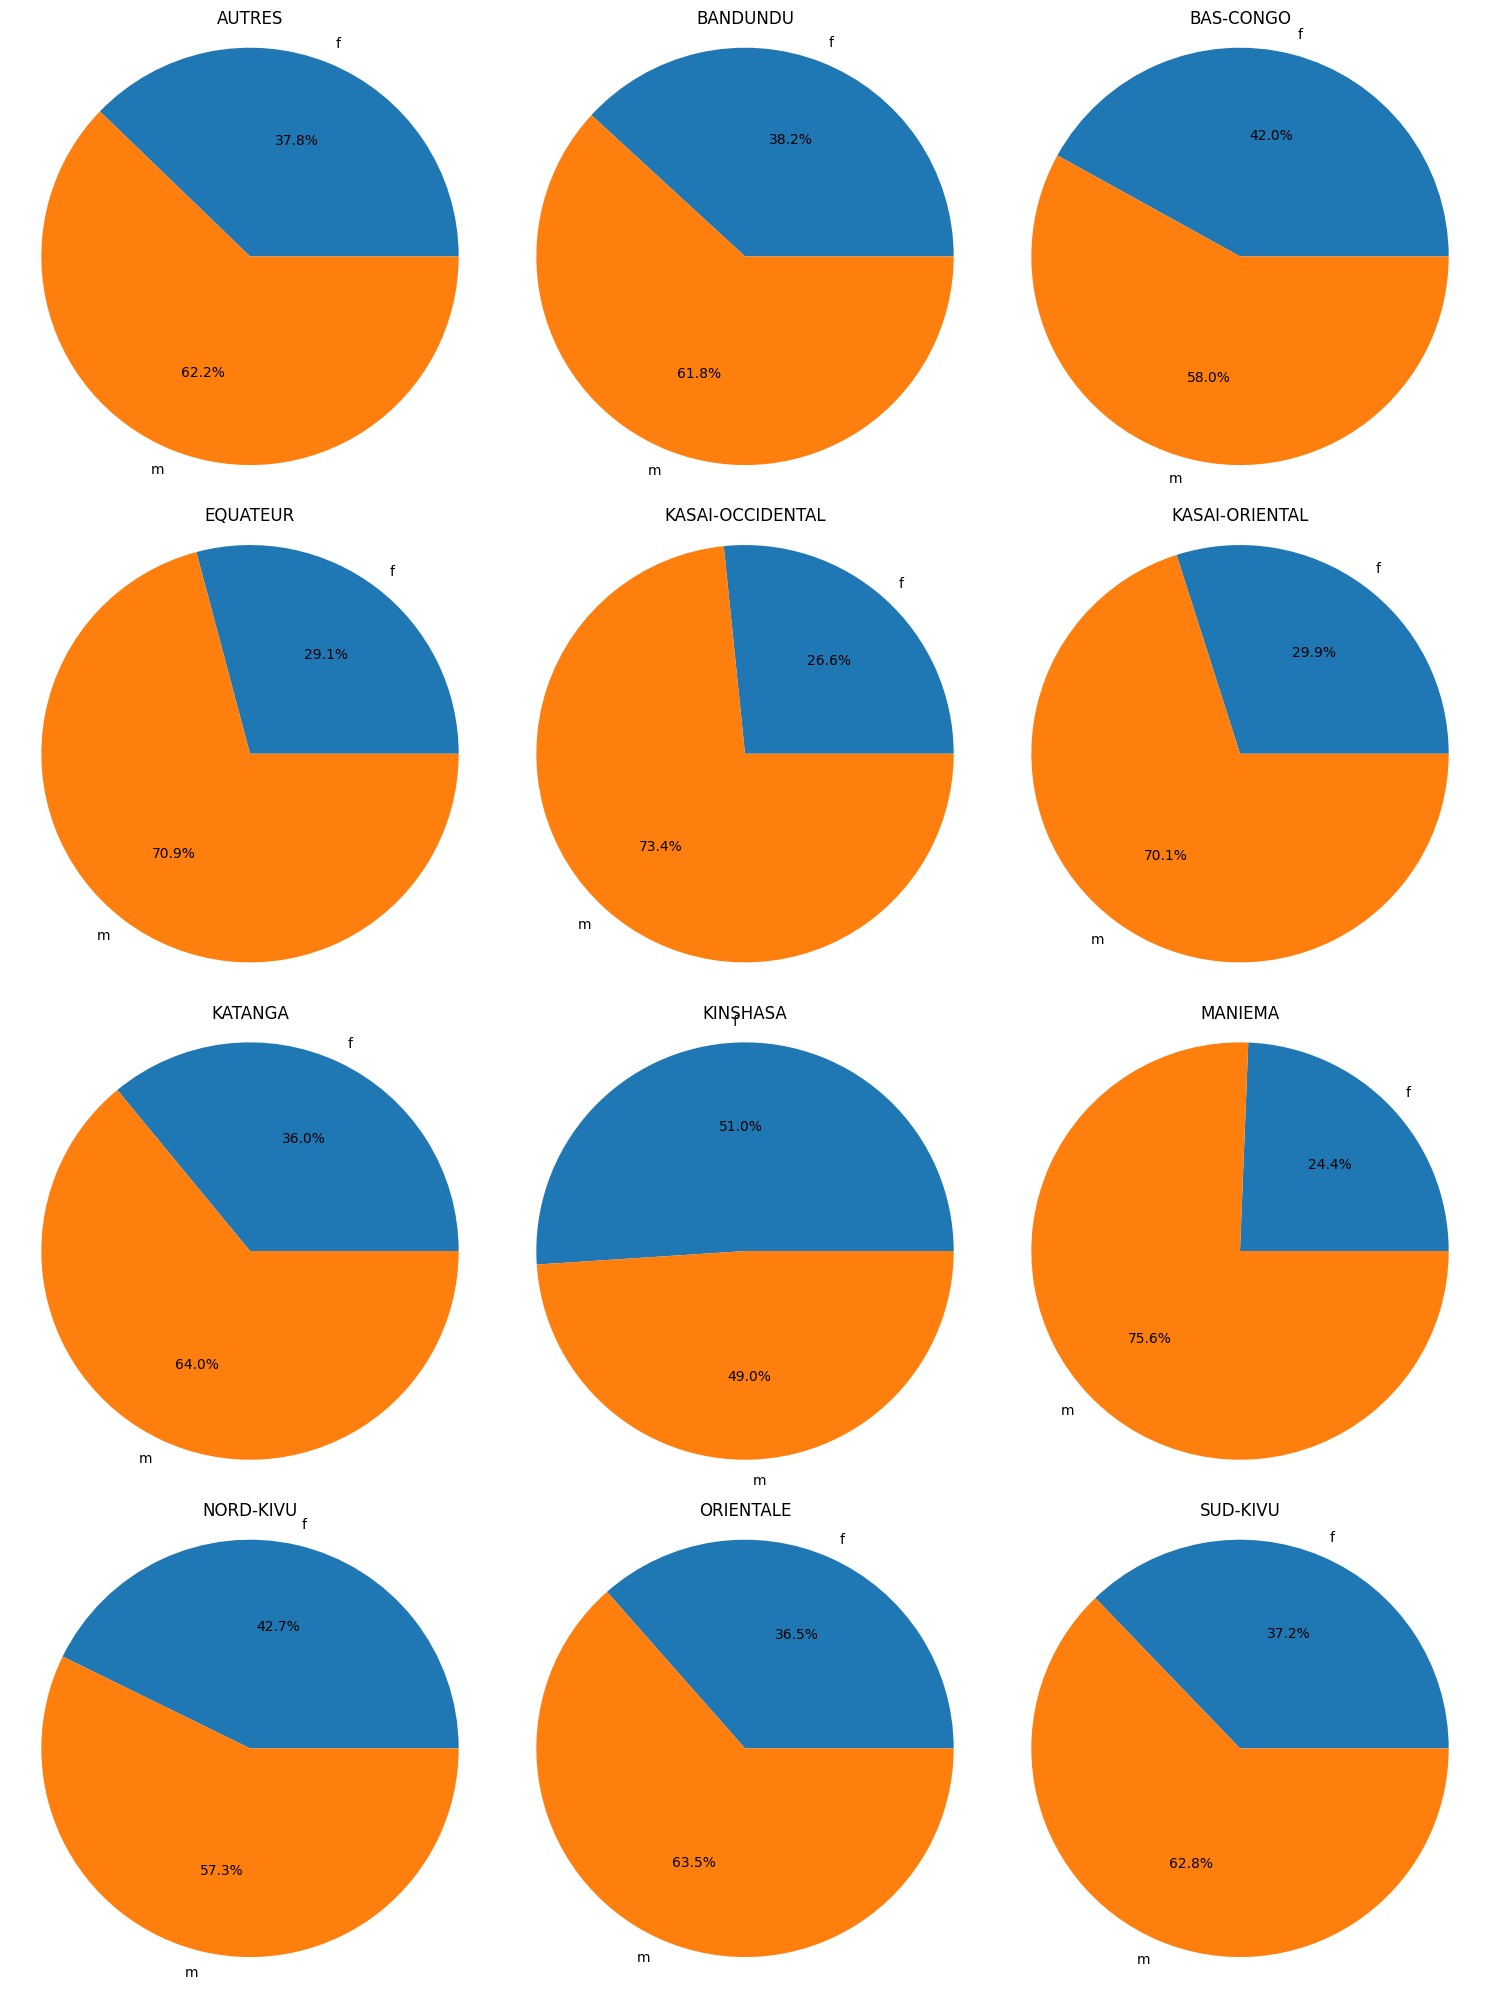

In [12]:
df_provinces_sex_counts = (
    df.groupby(["province", "sex"], observed=False).size().reset_index(name="count")
)
provinces = df_provinces_sex_counts["province"].unique()
cols = 3
rows = (len(provinces) + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 5))
for i, province in enumerate(provinces, 1):
    data = df_provinces_sex_counts[df_provinces_sex_counts["province"] == province]
    plt.subplot(rows, cols, i)
    plt.pie(data["count"], labels=data["sex"], autopct="%1.1f%%")
    plt.title(province)
    plt.axis("equal")

plt.tight_layout()
plt.show()

## Names

In [13]:
# breakdown of names into surname, middle name and first name
# retrieve all rows whose name is identified as simple, and delete rows whose identified_name is null or empty

df_simple = df[df["identified_category"] == "simple"].copy()
df_simple["surname"] = df_simple["identified_name"].str.split().str[0]
df_simple["middle_name"] = df_simple["identified_name"].str.split().str[1]
df_simple["first_name"] = df_simple["identified_surname"]
df_simple = df_simple[
    df_simple["first_name"].notna() & (df_simple["first_name"].str.strip() != "")
]

df_simple[["name", "surname", "middle_name", "first_name"]].head()

,name,surname,middle_name,first_name
0,dikoko pamitshefu fabrice,dikoko,pamitshefu,fabrice
1,epenge djongesongo jonas,epenge,djongesongo,jonas
2,eyongoyongo shako michel,eyongoyongo,shako,michel
3,kassongo osango israel,kassongo,osango,israel
4,okawonga ongondjo alphonse,okawonga,ongondjo,alphonse


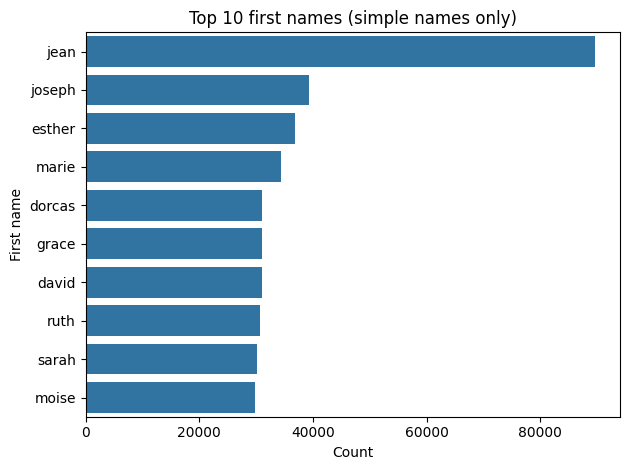

In [14]:
# Simple distribution of first names (display of the 10 most popular first names)
sns.countplot(
    y=df_simple["first_name"],
    order=df_simple["first_name"].value_counts().iloc[:10].index,
)
plt.title("Top 10 first names (simple names only)")
plt.xlabel("Count")
plt.ylabel("First name")
plt.tight_layout()
plt.show()

In [15]:
firstnames = df_simple["first_name"].value_counts()
df_firstnames = firstnames.reset_index()
df_firstnames.columns = ["First name", "quantity"]
df_firstnames.head(10)

,First name,quantity
0,jean,89561
1,joseph,39365
2,esther,36778
3,marie,34401
4,dorcas,31094
5,grace,31052
6,david,30970
7,ruth,30733
8,sarah,30188
9,moise,29789


In [16]:
# Most common first name by province
top_names = (
    df_simple.groupby(["province_clean", "first_name"]).size().reset_index(name="count")
)
top_names = top_names.sort_values(["province_clean", "count"], ascending=[True, False])
top_names = top_names.drop_duplicates(subset="province_clean", keep="first")
gdf_named = gdf_merged.merge(
    top_names[["province_clean", "first_name"]],
    left_on="province_upper",
    right_on="province_clean",
    how="left",
)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column="count", cmap="Blues", edgecolor="black", legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row["first_name"]):
        centroid = row["geometry"].centroid
        label = f"{row['first_name']}"
        plt.text(
            centroid.x,
            centroid.y,
            label,
            horizontalalignment="center",
            fontsize=8,
            color="black",
        )

plt.title("Most common first name by province")
plt.axis("off")
plt.show()

KeyError: 'province_clean'

In [ ]:
# Total number of distinct first names
total_firstnames = df_simple["first_name"].notna().sum()
print(f">> Total number of first names registered : {total_firstnames}")

# categorization of first names
firstnames_by_sex = (
    df_simple.groupby(["first_name", "sex"]).size().unstack(fill_value=0)
)
male_firstnames = firstnames_by_sex[
    (firstnames_by_sex["m"] > 0) & (firstnames_by_sex["f"] == 0)
]
print(f">> Number of all-male first names : {len(male_firstnames)}")
female_firstnames = firstnames_by_sex[
    (firstnames_by_sex["f"] > 0) & (firstnames_by_sex["m"] == 0)
]
print(f">> Number of all-female first names : {len(female_firstnames)}")
neutral_firstnames = firstnames_by_sex[
    (firstnames_by_sex["m"] > 0) & (firstnames_by_sex["f"] > 0)
]
print(f">> Number of all-neutral first names : {len(neutral_firstnames)}")

>> Total number of first names registered : 3392438
>> Number of all-male first names : 110947
>> Number of all-female first names : 61318
>> Number of all-neutral first names : 26593


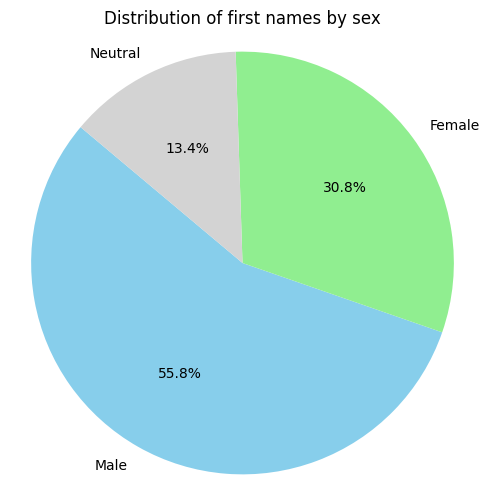

In [ ]:
# data for graphic interpretation
labels = ["Male", "Female", "Neutral"]
values = [len(male_firstnames), len(female_firstnames), len(neutral_firstnames)]

# circular
plt.figure(figsize=(6, 6))
plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=["skyblue", "lightgreen", "lightgray"],
)
plt.title("Distribution of first names by sex")
plt.axis("equal")
plt.show()

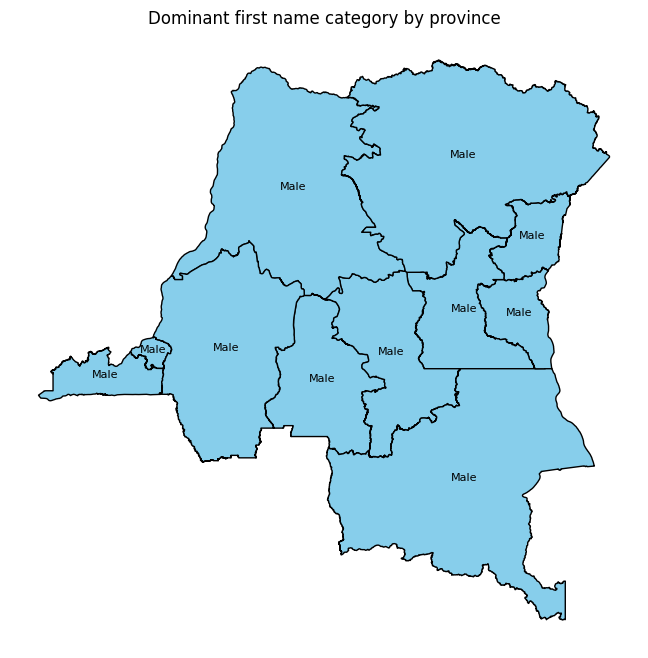

In [ ]:
# Assign first name sex category
df_simple["first_name_sex_category"] = df_simple["first_name"].map(
    lambda x: "Male"
    if x in male_firstnames
    else (
        "Female"
        if x in female_firstnames
        else ("Neutral" if x in neutral_firstnames else None)
    )
)

df_cat = df_simple.dropna(subset=["first_name_sex_category"])
category_counts = (
    df_cat.groupby(["province_clean", "first_name_sex_category"])
    .size()
    .unstack(fill_value=0)
)
category_counts["dominant_category"] = category_counts.idxmax(axis=1)
map_df = gdf.set_index("province_upper").join(category_counts["dominant_category"])

color_map = {"Male": "skyblue", "Female": "lightgreen", "Neutral": "lightgray"}
map_df["color"] = map_df["dominant_category"].map(color_map)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
map_df.plot(color=map_df["color"], edgecolor="black", ax=ax)
for idx, row in map_df.iterrows():
    plt.annotate(
        text=row["dominant_category"],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        horizontalalignment="center",
        fontsize=8,
        color="black",
    )

plt.title("Dominant first name category by province")
plt.axis("off")
plt.show()

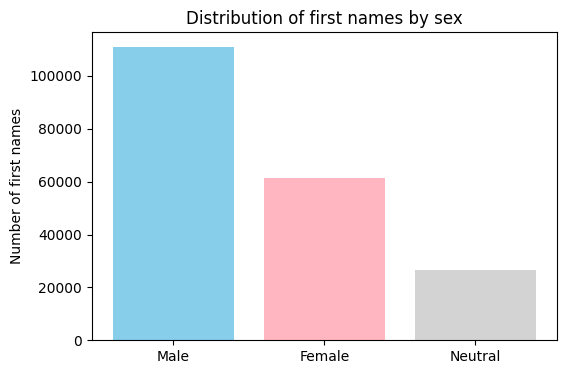

In [ ]:
# Histogram
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=["skyblue", "lightpink", "lightgray"])
plt.title("Distribution of first names by sex")
plt.ylabel("Number of first names")
plt.show()

In [ ]:
# Count of unique first names per region (province)
distinct_regions = df_simple["province"].nunique()
print(f">> Number of distinct regions: {distinct_regions}")
firstnames_by_region = (
    df_simple.groupby("province")["first_name"].nunique().sort_values(ascending=False)
)

print("Number of unique first names per region")
df_firstnames_region = firstnames_by_region.reset_index()
df_firstnames_region.columns = ["Region", "Unique first names"]
df_firstnames_region.head(12)

>> Number of distinct regions: 12
Number of unique first names per region


,Region,Unique first names
0,kinshasa,75509
1,bandundu,43309
2,katanga,37932
3,autres,31487
4,nord-kivu,27300
5,equateur,25389
6,bas-congo,24154
7,sud-kivu,23834
8,orientale,18356
9,kasaï-oriental,15906


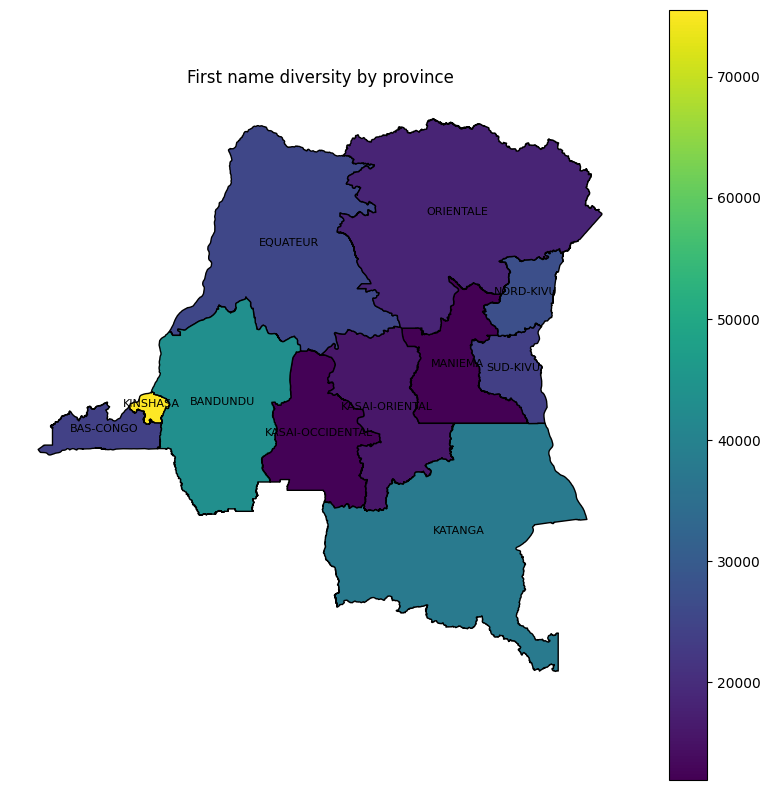

In [ ]:
unique_first_names = (
    df_simple.groupby("province")["first_name"]
    .nunique()
    .reset_index(name="unique_count")
)
unique_first_names["province_clean"] = (
    unique_first_names["province"]
    .str.upper()
    .str.strip()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)
gdf_diversity = gdf_merged.merge(
    unique_first_names[["province_clean", "unique_count"]],
    on="province_clean",
    how="left",
)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_diversity.plot(
    column="unique_count", cmap="viridis", edgecolor="black", legend=True, ax=ax
)

for idx, row in gdf_diversity.iterrows():
    centroid = row["geometry"].centroid
    plt.text(
        centroid.x,
        centroid.y,
        row["province_upper"],
        horizontalalignment="center",
        fontsize=8,
        color="black",
    )

plt.title("First name diversity by province")
plt.axis("off")
plt.show()

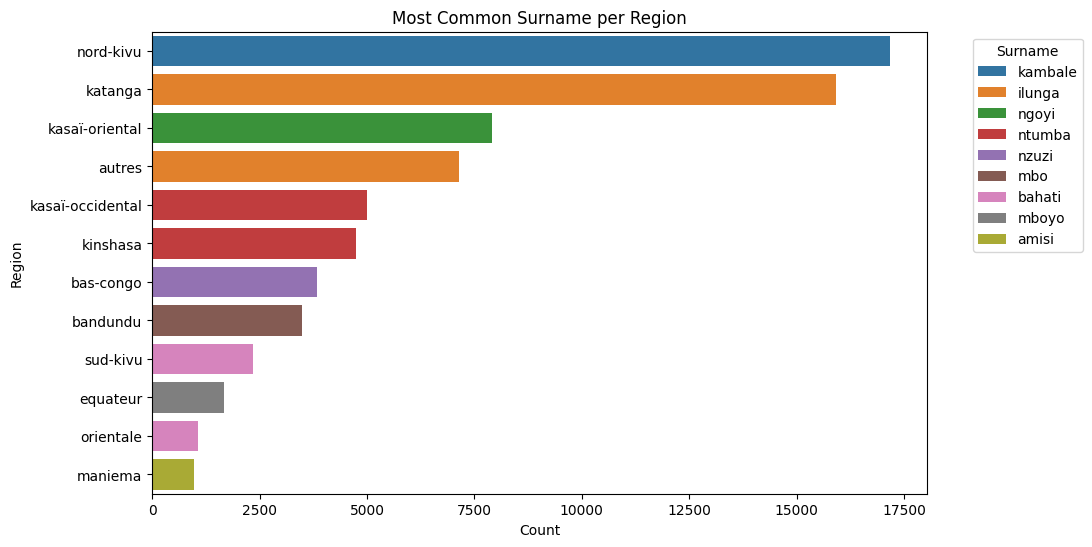

In [ ]:
# surnames per region (aggregated)
top_surnames_region = (
    surnames_by_region.sort_values("count", ascending=False)
    .drop_duplicates("province")
    .head(12)
)
plt.figure(figsize=(10, 6))
sns.barplot(
    y="province", x="count", data=top_surnames_region, hue="surname", dodge=False
)
plt.title("Most Common Surname per Region")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Surname", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

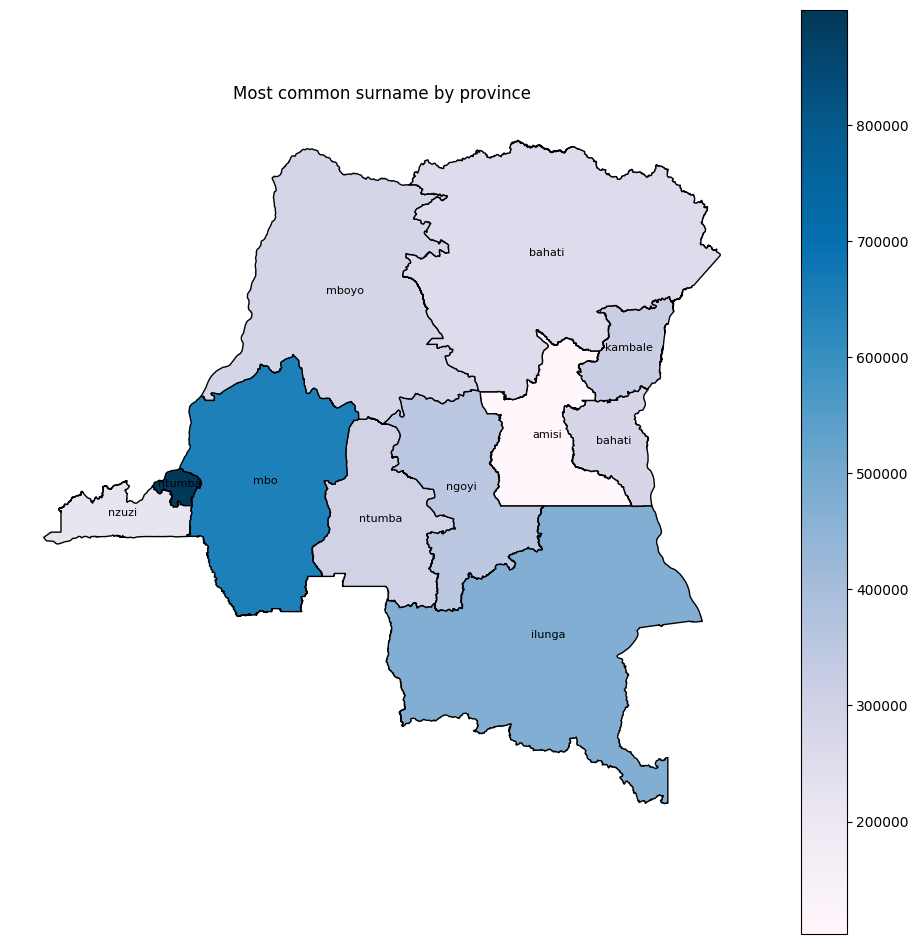

In [ ]:
# Map of the most common surname by province in DRC
top_surnames = (
    df_simple.groupby(["province", "surname"]).size().reset_index(name="count")
)
top_surnames = top_surnames.sort_values(["province", "count"], ascending=[True, False])
top_surnames = top_surnames.drop_duplicates(subset="province", keep="first")
top_surnames["province_clean"] = (
    top_surnames["province"]
    .str.upper()
    .str.strip()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

gdf_named = gdf_merged.merge(
    top_surnames[["province_clean", "surname"]], on="province_clean", how="left"
)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column="count", cmap="PuBu", edgecolor="black", legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row["surname"]):
        centroid = row["geometry"].centroid
        plt.text(
            centroid.x,
            centroid.y,
            row["surname"],
            horizontalalignment="center",
            fontsize=8,
            color="black",
        )

plt.title("Most common surname by province")
plt.axis("off")
plt.show()

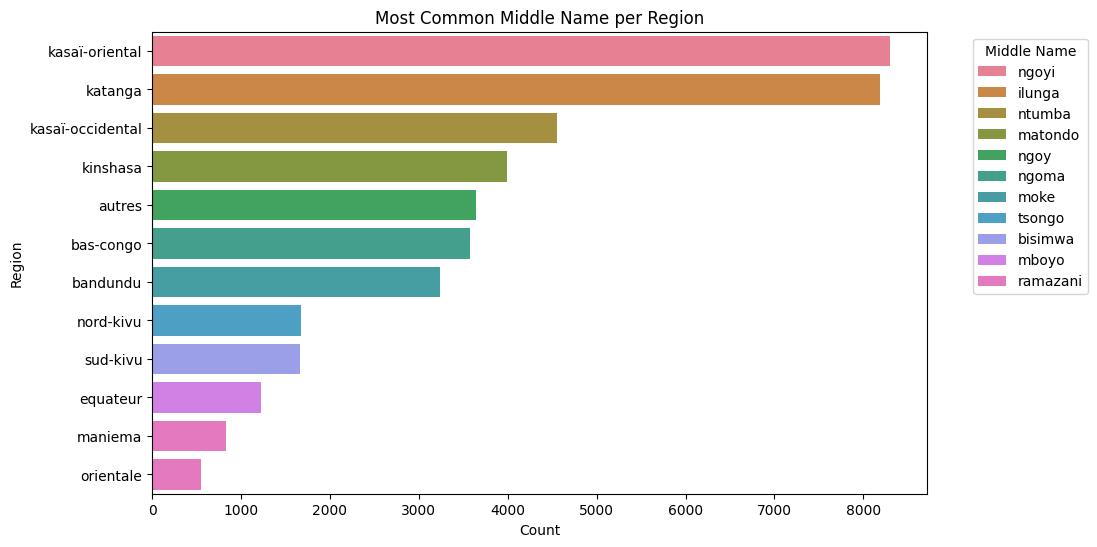

In [ ]:
# most popular middle name per region
top_middlename_region = (
    middlenames_by_region.sort_values("count", ascending=False)
    .drop_duplicates("province")
    .head(12)
)
plt.figure(figsize=(10, 6))
sns.barplot(
    y="province", x="count", data=top_middlename_region, hue="middle_name", dodge=False
)
plt.title("Most Common Middle Name per Region")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Middle Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

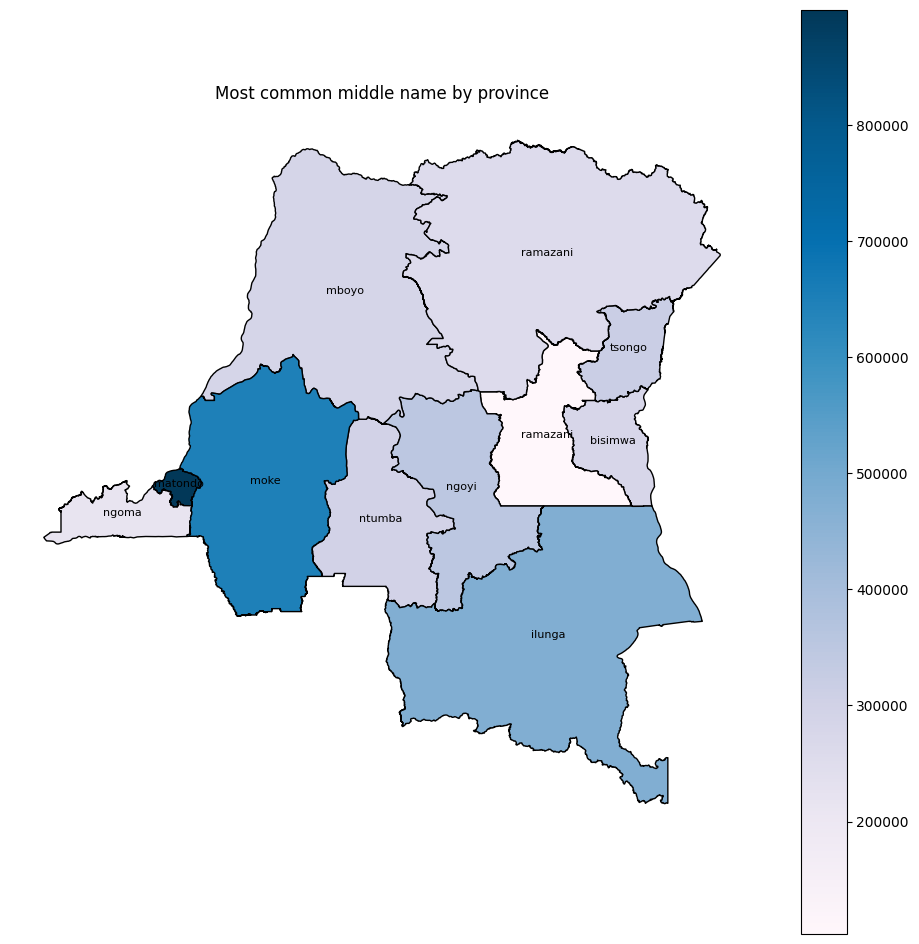

In [ ]:
# Map of the most common middle by province in DRC
top_surnames = (
    df_simple.groupby(["province", "middle_name"]).size().reset_index(name="count")
)
top_surnames = top_surnames.sort_values(["province", "count"], ascending=[True, False])
top_surnames = top_surnames.drop_duplicates(subset="province", keep="first")
top_surnames["province_clean"] = (
    top_surnames["province"]
    .str.upper()
    .str.strip()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

gdf_named = gdf_merged.merge(
    top_surnames[["province_clean", "middle_name"]], on="province_clean", how="left"
)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column="count", cmap="PuBu", edgecolor="black", legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row["middle_name"]):
        centroid = row["geometry"].centroid
        plt.text(
            centroid.x,
            centroid.y,
            row["middle_name"],
            horizontalalignment="center",
            fontsize=8,
            color="black",
        )

plt.title("Most common middle name by province")
plt.axis("off")
plt.show()